In [106]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
%matplotlib inline


In [107]:
sns.set()

In [108]:
df = pd.read_csv("automation-protocol-ii.csv")

In [109]:
df.columns = df.columns.str.lower()
df.head()

,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 22:58:04
1,271,65538,2,1605868423,1,efd275,48,2020-11-20 22:58:04
2,272,65540,2,1605882795,0,efd275,100,2020-11-20 22:58:04
3,273,65545,2,1605831076,0,efd275,50,2020-11-20 22:58:04
4,274,65546,2,1605892658,0,f1e0b5,50,2020-11-20 22:58:04


## Data cleaning

In [110]:
df.protocoltime = pd.to_datetime(df.protocoltime)
df.head()

,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 22:58:04
1,271,65538,2,1605868423,1,efd275,48,2020-11-20 22:58:04
2,272,65540,2,1605882795,0,efd275,100,2020-11-20 22:58:04
3,273,65545,2,1605831076,0,efd275,50,2020-11-20 22:58:04
4,274,65546,2,1605892658,0,f1e0b5,50,2020-11-20 22:58:04


In [111]:
df.protocoltime = df.protocoltime.round('15min')
df.head()

,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:00:00
1,271,65538,2,1605868423,1,efd275,48,2020-11-20 23:00:00
2,272,65540,2,1605882795,0,efd275,100,2020-11-20 23:00:00
3,273,65545,2,1605831076,0,efd275,50,2020-11-20 23:00:00
4,274,65546,2,1605892658,0,f1e0b5,50,2020-11-20 23:00:00


### Data enriching

In [112]:
devices = df.instanceid.unique()
devices

array([65537, 65538, 65540, 65545, 65546, 65547, 65548, 65549, 65551,
       65552, 65553, 65554, 65555, 65556, 65557])

In [113]:
absolute_min_date = df.protocoltime.min(axis=0)
absolute_max_date = df.protocoltime.max(axis=0)
print("absolute_min_date=%s, absolute_max_date=%s" % (absolute_min_date, absolute_max_date))

complete_time_data = pd.date_range(absolute_min_date, absolute_max_date, freq="15min")
complete_time_data = complete_time_data.tz_localize(None)

complete_arr = []

for device in devices:
    single_device = df[df["instanceid"] == device]
    single_device["protocoltime"] = pd.to_datetime(single_device["protocoltime"]).apply(lambda x: x.replace(tzinfo=None))
    last_state = single_device.iloc[0]
    last_state["onoff"] = 0
    for time_data in complete_time_data.values:
        if time_data in single_device.protocoltime.values:
            # TODO edge case for multiple events in one time slot
            device_row = single_device[single_device["protocoltime"] == time_data]
            complete_arr.append(device_row.values[0])
            last_state = device_row.iloc[0]
        else:
            current_state = last_state.copy()
            current_state["protocoltime"] = time_data
            complete_arr.append(current_state.values)

df = pd.DataFrame(complete_arr, columns=df.columns)
df = df.sort_values(by=["instanceid", "protocoltime"])
df.head()

absolute_min_date=2020-11-20 23:00:00, absolute_max_date=2020-11-28 18:15:00


,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:00:00
1,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:15:00
2,285,65537,2,1605867202,1,efd275,51,2020-11-20 23:30:00
3,285,65537,2,1605867202,1,efd275,51,2020-11-20 23:45:00
4,304,65537,2,1605867202,0,f1e0b5,51,2020-11-21 00:00:00


In [114]:
len(df)

11250

In [115]:
df.color[df.color == 0] = "f1e0b5" 

In [116]:
df["weekday"] = df.protocoltime.dt.day_name()
df["weekofyear"] = df.protocoltime.dt.weekofyear
df["year"] = df.protocoltime.dt.year
df["month"] = df.protocoltime.dt.month
df["day"] = df.protocoltime.dt.day
df["time"] = df.protocoltime.dt.strftime("%H:%M")
df.head()

,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime,weekday,weekofyear,year,month,day,time
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:00:00,Friday,47,2020,11,20,23:00
1,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:15:00,Friday,47,2020,11,20,23:15
2,285,65537,2,1605867202,1,efd275,51,2020-11-20 23:30:00,Friday,47,2020,11,20,23:30
3,285,65537,2,1605867202,1,efd275,51,2020-11-20 23:45:00,Friday,47,2020,11,20,23:45
4,304,65537,2,1605867202,0,f1e0b5,51,2020-11-21 00:00:00,Saturday,47,2020,11,21,00:00


In [117]:
df.columns

Index(['id', 'instanceid', 'type', 'lastseen', 'onoff', 'color', 'dimmer',
       'protocoltime', 'weekday', 'weekofyear', 'year', 'month', 'day',
       'time'],
      dtype='object')

In [118]:
df.color.unique()

array(['efd275', 'f1e0b5', 'f5faf6', '0', 'f2eccf', 'ffe2c4'],
      dtype=object)

In [119]:
df.color.value_counts()

f1e0b5    8326
efd275    1338
f5faf6    1094
0          206
ffe2c4     192
f2eccf      94
Name: color, dtype: int64

In [120]:
if "id" in df.columns:
    del df["id"]
if "lastseen" in df.columns:
    del df["lastseen"]
if "protocoltime" in df.columns:
    del df["protocoltime"]
df.head()

,instanceid,type,onoff,color,dimmer,weekday,weekofyear,year,month,day,time
0,65537,2,1,efd275,51,Friday,47,2020,11,20,23:00
1,65537,2,1,efd275,51,Friday,47,2020,11,20,23:15
2,65537,2,1,efd275,51,Friday,47,2020,11,20,23:30
3,65537,2,1,efd275,51,Friday,47,2020,11,20,23:45
4,65537,2,0,f1e0b5,51,Saturday,47,2020,11,21,00:00


## Data exploration

In [121]:
df.to_csv("parsed-data.csv", index=False)

In [122]:
df.describe()

,instanceid,type,onoff,dimmer,weekofyear,year,month,day
count,11250.000000,11250.0,11250.000000,11250.000000,11250.000000,11250.0,11250.0,11250.000000
mean,65548.533333,2.0,0.349956,80.741422,47.738667,2020.0,11.0,24.373333
std,6.195614,0.0,0.476977,26.302173,0.439381,0.0,0.0,2.260327
min,65537.000000,2.0,0.000000,8.000000,47.000000,2020.0,11.0,20.000000
25%,65545.000000,2.0,0.000000,50.000000,47.000000,2020.0,11.0,22.000000
50%,65549.000000,2.0,0.000000,100.000000,48.000000,2020.0,11.0,24.000000
75%,65554.000000,2.0,1.000000,100.000000,48.000000,2020.0,11.0,26.000000
max,65557.000000,2.0,1.000000,100.000000,48.000000,2020.0,11.0,28.000000


In [123]:
df.isnull().sum()

instanceid    0
type          0
onoff         0
color         0
dimmer        0
weekday       0
weekofyear    0
year          0
month         0
day           0
time          0
dtype: int64

In [124]:
df.time.unique()

array(['23:00', '23:15', '23:30', '23:45', '00:00', '00:15', '00:30',
       '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15',
       '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00',
       '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45',
       '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30',
       '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15',
       '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00',
       '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45',
       '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30',
       '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15',
       '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00',
       '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45',
       '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30',
       '21:45', '22:00', '22:15', '22:30', '22:45'], dtype=object)

In [125]:
pd.Timestamp("16:15").round("1h").strftime("%H:%M")

'16:00'

### Distribution of on/off states

on=3937, off=7313


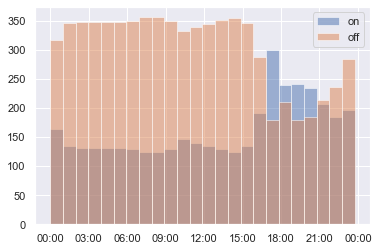

In [247]:
time_df = df.copy()
time_df.time = time_df.time.map(lambda x: pd.Timestamp(x).round('15min'))
time_df_on = time_df[time_df.onoff == 1].time
time_df_off = time_df[time_df.onoff == 0].time

print("on=%d, off=%d" % (len(time_df_on), len(time_df_off)))

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.hist(time_df_on, bins=24, label="on", alpha=0.5)
plt.hist(time_df_off, bins=24, label="off", alpha=0.5)
# ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 23, 1)))
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.legend()
plt.show()

### distribution of on states over time with KDE

In [259]:
print("time_df:\n", time_df.head())

time_df_cnt = time_df.copy()
time_df_cnt.time = time_df_cnt.time.map(lambda x: x.strftime("%H:%M"))

print("time_df_cnt:\n", time_df_cnt.groupby(["time", "onoff"]).agg("count"))

time_df:
    instanceid  type  onoff                time
0       65537     2      1 2020-11-28 23:00:00
1       65537     2      1 2020-11-28 23:15:00
2       65537     2      1 2020-11-28 23:30:00
3       65537     2      1 2020-11-28 23:45:00
4       65537     2      0 2020-11-28 00:00:00
time_df_cnt:
              instanceid  type
time  onoff                  
00:00 0              78    78
      1              42    42
00:15 0              78    78
      1              42    42
00:30 0              77    77
...                 ...   ...
23:15 1              48    48
23:30 0              71    71
      1              49    49
23:45 0              72    72
      1              48    48

[192 rows x 2 columns]


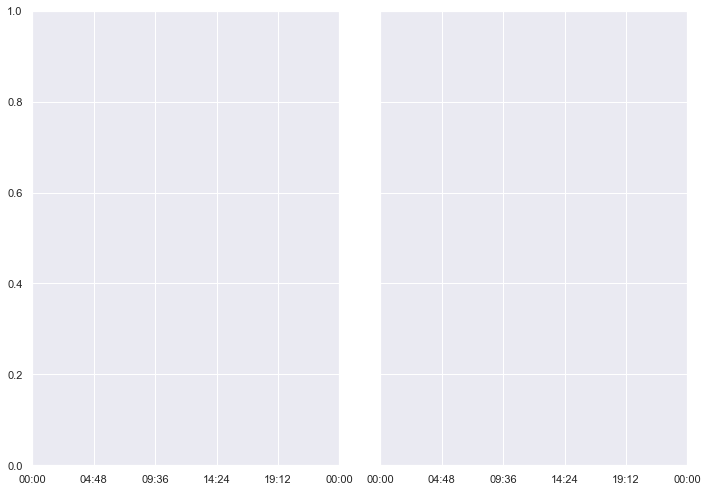

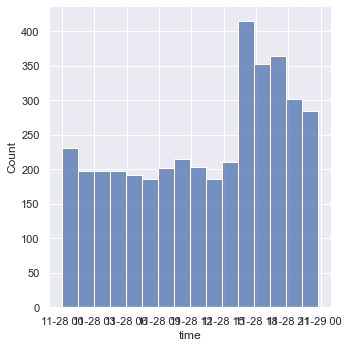

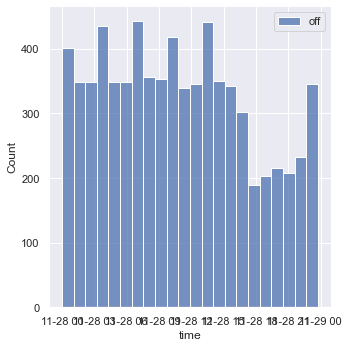

In [269]:
figure, (ax01, ax02) = plt.subplots(ncols=2, figsize=(10, 7), sharey=True)
sns.displot(data=time_df_on, label="on", ax=ax01)
ax01.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
sns.displot(data=time_df_off, label="off", ax=ax01)
ax02.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# ax = plt.gca()
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
figure.tight_layout()
plt.legend()
plt.show()

### On state for specific lamp over time

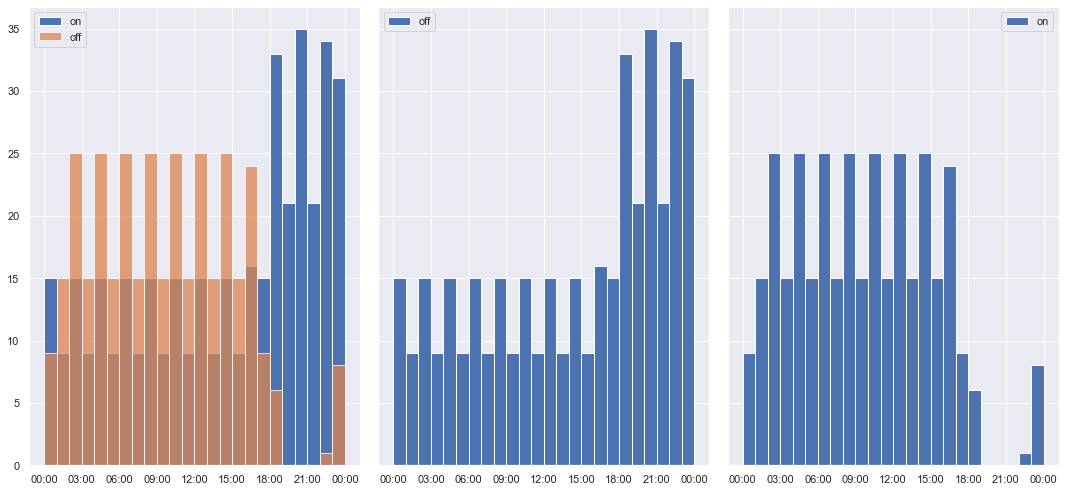

In [230]:
lamp_df = df.copy()
lamp_df = lamp_df[lamp_df.instanceid == 65538]
lamp_df.time = lamp_df.time.map(lambda x: pd.Timestamp(x).round('1h'))
lamp_df_on = lamp_df[lamp_df.onoff == 1].time
lamp_df_off = lamp_df[lamp_df.onoff == 0].time

figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7), sharey=True)
ax01 = axes[0]
ax01.hist(lamp_df_on, bins=24, label="on", alpha=1)
ax01.hist(lamp_df_off, bins=24, label="off", alpha=0.75)
ax01.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax01.legend()

ax02 = axes[1]
ax02.hist(lamp_df_on, bins=24, label="off")
ax02.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax02.legend()

ax03 = axes[2]
ax03.hist(lamp_df_off, bins=24, label="on")
ax03.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax03.legend()

figure.tight_layout()
plt.show()

## Data preparation

In [129]:
del df["weekday"]
del df["weekofyear"] 
del df["year"] 
del df["month"] 
del df["day"]
del df["color"]
del df["dimmer"]
df.head()

,instanceid,type,onoff,time
0,65537,2,1,23:00
1,65537,2,1,23:15
2,65537,2,1,23:30
3,65537,2,1,23:45
4,65537,2,0,00:00


In [130]:
from sklearn.model_selection import train_test_split

In [131]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [132]:
y_train_full_onoff = (df_train_full.onoff == 1).values
y_train_onoff = (df_train.onoff == 1).values
y_val_onoff = (df_val.onoff == 1).values
y_test_onoff = (df_test.onoff == 1).values

In [133]:
del df_train_full["onoff"]
del df_train["onoff"]
del df_val["onoff"]
del df_test["onoff"]

### One-Hot encoding

In [134]:
from sklearn.feature_extraction import DictVectorizer

In [135]:
dv = DictVectorizer(sparse=False)
dv_full = DictVectorizer(sparse=False)

In [136]:
dict_train_full_onoff = df_train_full.to_dict(orient="records")
dict_train_onoff = df_train.to_dict(orient="records")
dict_val_onoff = df_val.to_dict(orient="records")
dict_test_onoff = df_test.to_dict(orient="records")

In [137]:
X_train_full_onoff = dv_full.fit_transform(dict_train_full_onoff)
X_train_onoff = dv.fit_transform(dict_train_onoff)
X_val_onoff = dv.transform(dict_val_onoff)
X_test_onoff = dv_full.transform(dict_test_onoff)

## Training

### Logistic Regression

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#### Optimization

In [139]:
for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    lr = LogisticRegression(solver='liblinear', C=C, random_state=1)
    lr.fit(X_train_onoff, y_train_onoff)
    
    y_pred = lr.predict_proba(X_val_onoff)[:, 1]
    
    auc = roc_auc_score(y_val_onoff, y_pred)
    print('C=%s, auc = %0.3f' % (C, auc))


C=0.001, auc = 0.606
C=0.01, auc = 0.606
C=0.1, auc = 0.606
C=0.5, auc = 0.606
C=1, auc = 0.606
C=10, auc = 0.606


In [140]:
#### Final model

In [141]:
lr = LogisticRegression(solver='liblinear', C=0.1, random_state=1)
lr.fit(X_train_full_onoff, y_train_full_onoff)

LogisticRegression(C=0.1, random_state=1, solver='liblinear')

In [142]:
# dict(zip(dv.get_feature_names(), lr.coef_[0].round(5)))

### Decision trees

In [143]:
from sklearn.tree import DecisionTreeClassifier

#### Final model

In [144]:
dt = DecisionTreeClassifier()
dt.fit(X_train_full_onoff, y_train_full_onoff)

DecisionTreeClassifier()

### Random forest

In [145]:
from sklearn.ensemble import RandomForestClassifier

#### Final model

In [146]:
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train_full_onoff, y_train_full_onoff)

RandomForestClassifier(n_estimators=10, random_state=3)

## Evaluation

### Logistic regression

In [147]:
y_pred = lr.predict_proba(X_test_onoff)[:, 1]
accuracy = (y_test_onoff == (y_pred >= 0.5)).mean()

auc = roc_auc_score(y_test_onoff, y_pred)

print("LR accuracy:", accuracy)
print("LR auc:", auc)

LR accuracy: 0.6475555555555556
LR auc: 0.5813972811171186


### Decision trees

In [148]:
y_pred = dt.predict_proba(X_test_onoff)[:, 1]
accuracy = (y_test_onoff == (y_pred >= 0.5)).mean()

auc = roc_auc_score(y_test_onoff, y_pred) 

print("LR accuracy:", accuracy)
print("LR auc:", auc)

LR accuracy: 0.6564444444444445
LR auc: 0.5797891814183993


### Random forest

In [149]:
y_pred = rf.predict_proba(X_test_onoff)[:, 1]
accuracy = (y_test_onoff == (y_pred >= 0.5)).mean()

auc = roc_auc_score(y_test_onoff, y_pred)

print("LR accuracy:", accuracy)
print("LR auc:", auc)

LR accuracy: 0.6724444444444444
LR auc: 0.5812116312864538


## Testing the model(s)

In [150]:
example = {
    "instanceid": 65537,
    "type": 2,
    # "weekday": "Tuesday",
    "time": "22:00"
}

In [151]:
X_example = dv_full.transform([example])
pd.DataFrame(X_example, columns=dv.get_feature_names())

,instanceid,time=00:00,time=00:15,time=00:30,time=00:45,time=01:00,time=01:15,time=01:30,time=01:45,time=02:00,...,time=21:45,time=22:00,time=22:15,time=22:30,time=22:45,time=23:00,time=23:15,time=23:30,time=23:45,type
0,65537.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [152]:
lr.predict_proba(X_example)[0, 1]

0.3493513052272147

In [153]:
lr.predict_proba(X_example)[0, 1] >= 0.5

False